In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [15]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

# Standard library imports
import os
from functools import partial
from math import pi
import json
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Imports for working with shapefiles
import pyproj
from shapely.geometry import (
    shape,
    MultiPolygon,
    mapping
)
from shapely.ops import (
    transform,
    cascaded_union
)
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex
from matplotlib import cm
%matplotlib inline

# local imports
from src.modelling.clustering import SameSizeKMeans
from src.output.shapes import (
    generate_colors,
    plot_shapes,
    generate_shapefiles,
    geojson_from_shapefile
)

In [4]:
# Create pandas dataframes that have information about each blockgroup
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)

pop18_df = pd.read_csv('data/block_groups/pop18/DEC_10_SF1_P10_with_ann.csv')
pop18_df = pop18_df[['GEO.id2', 'D001', 'D003']]
pop18_df.columns = ['geoid', 'pop18', 'pop18wht']
pop18_df.drop(0, axis=0, inplace=True)
pop18_df.set_index('geoid', inplace=True)

In [5]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

# A convenience object for projecting lat/long values
# from EPSG 4326 to 3695 (approximate xy mappings for
# central Wisconsin)
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [6]:
# Create a list of blockgroups, which has a shape, a geoid,
# and an untransformed shape
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
            'geoid': block['properties']['GEOID'],
            'untransformed': shape(block['geometry'])
        }
        for block in f
    ]

In [7]:
# Assign information for each block from the above dataframes
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])
    block['pop18'] = int(pop18_df.loc[block['geoid']]['pop18'])
    block['pop18wht'] = int(pop18_df.loc[block['geoid']]['pop18wht'])
    block['poptot'] = int(poptot_df.loc[block['geoid']]['poptot'])

In [8]:
# Create shapes of the whole of Wisconsin to be used
# as cutouts for final districts to improve the quality
# of their presentation
with fiona.open('data/districts/congressional/Wisconsin_Congressional_Districts.shp') as f:
    wisconsin = cascaded_union([transform(project, shape(district['geometry'])) for district in f])
    wisc_untrans = cascaded_union([shape(district['geometry']) for district in f])

# Long, Lat bounds of the state for future reference
print(wisc_untrans.bounds)

(-92.8894329062527, 42.49191474914349, -86.76398658736599, 47.08077430717272)


In [9]:
# Create variable which is the ideal district population
# for a Congressional district in Wisconsin
total_wisc_pop = np.sum([block['poptot'] for block in blocks])
ideal_dist_pop = total_wisc_pop/8

In [10]:
def cleanup_blocks(blocks, labels):
    dist_blocks = {
    label: [block for block in blocks
            if block['label'] == label]
    for label in np.unique(labels)
    }
    
    for label in dist_blocks:
        _blocks = dist_blocks[label]
        for block in _blocks:
            if block['iscontiguous']:
                continue
            for other_block in _blocks:
                if block['geoid'] != other_block['geoid']:
                    if block['shape'].touches(other_block['shape']):
                        block['iscontiguous'] = True
                        other_block['iscontiguous'] = True
                        break
                    else:
                        block['iscontiguous'] = False
    
    for block in blocks:
        votes = defaultdict(int)
        if block['iscontiguous']:
            continue
        for other_block in blocks:
            if other_block['geoid'] == block['geoid']:
                continue
            if other_block['shape'].touches(block['shape']):
                votes[other_block['label']] +=1
        new_label = max(votes, key=votes.get)
        block['label'] = new_label

In [11]:
coord_array = np.array([block['centroid'] for block in blocks])
weight_array = np.array([block['poptot'] for block in blocks])

In [12]:
sskmeans = SameSizeKMeans(n_clusters=8, save_labels=True)
sskmeans.fit(
    coord_array, weights=weight_array,
    weight_tol=2e-3, order='s')

Starting step  1
Starting step  2
Starting step  3
Starting step  4
Starting step  5
Starting step  6
Starting step  7


In [13]:
all_labels = sskmeans.all_labels_

In [ ]:
# EPSG specification to use - lat/long
epsg_spec = 4326

for step, labels in enumerate(all_labels):
    print('Starting step',step)
    
    # Assign labels to each blockgroup for current step
    for label, block in zip(labels, blocks):
        block['label'] = int(label)
        block['iscontiguous'] = False
    
    # Make blockgroups contiguous by label
    while not all([block['iscontiguous'] for block in blocks]):
        print('Making blocks contiguous')
        cleanup_blocks(blocks, labels)
        
    # Create a dictionary of districts by label, and assign
    # their (untransformed) shape to be the union of all the
    # (untransformed) shapes of the blocks with that label
    districts = [{} for label in np.unique(labels)]
    
    for label in np.unique(labels):
        districts[label]['shape'] = cascaded_union([
            block['shape']
            for block in blocks
            if block['label'] == label
        ])

        districts[label]['untransformed'] = cascaded_union([
            block['untransformed']
            for block in blocks
            if block['label'] == label
        ])
        
        districts[label]['id'] = int(label) + 1
    
    # Assign population totals, compactness, etc. to each district
    for label in np.unique(labels):
        
        # population total
        _tot_pop = np.sum([
            block['poptot']
            for block in blocks
            if block['label'] == label
        ])
        districts[label]['poptot'] = _tot_pop
        
        # total voting age population
        _tot_pop18 = np.sum([
            block['pop18']
            for block in blocks
            if block['label'] == label
        ])
        districts[label]['pop18'] = _tot_pop18
        
        # total white voting age population
        _tot_pop18wht = np.sum([
            block['pop18wht']
            for block in blocks
            if block['label'] == label
        ])
        districts[label]['pop18wht'] = _tot_pop18wht
        
        # District compactness
        _area = districts[label]['shape'].area/(1000)**2
        _perimeter = districts[label]['shape'].length/1000
        districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
        
        # scaled population difference from ideal
        _pop_diff = _tot_pop - ideal_dist_pop
        districts[label]['popdiff'] = (1 + _pop_diff/ideal_dist_pop)/2
    
    # Categorical district colors
    hex_dist_colors = {
        district['id']: to_hex(cm.Set1(district['id'] - 1))
        for district in districts
    }
    
    # Compactness district colors with reference to a
    # 3x2 rectangle
    ref_aspect = 1.5
    reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
    cmpct_hex_colors = {
        district['id']: to_hex(cm.Reds_r(district['compactness']/reference))
        for district in districts
    }
    
    # Population difference colors
    popdiff_hex_colors = {
        district['id']: to_hex(cm.seismic(district['popdiff']))
        for district in districts
    }
    
    # Set the schema for the shapefile
    schema = {
        'type': 'Feature',
        'geometry': 'Polygon',
        'properties': {
            'id': 'int',
            'id_color': 'str',
            'cmpctness': 'float',
            'cmpct_col': 'str',
            'popdiff': 'float',
            'pdiff_col': 'str',
            'poptot': 'int',
            'pop18': 'int',
            'pop18wht': 'int'
        }
    }
    
    # Set the values associated for each field of the schema
    # for each district in districts
    all_schema_values = [
        {
            'type': 'Feature',
            'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
            'properties': {
                'id': district['id'],
                'id_color': hex_dist_colors[district['id']],
                'cmpctness': district['compactness'],
                'cmpct_col': cmpct_hex_colors[district['id']],
                'popdiff': district['popdiff'],
                'pdiff_col': popdiff_hex_colors[district['id']],
                'poptot': district['poptot'],
                'pop18': district['pop18'],
                'pop18wht': district['pop18wht']
            }
        }
        for district in districts
    ]
    
    # File location to write the shapefiles to
    file_folder = 'data/districts/generated/sskmeans{}'.format(step)
    
    # Make shapefiles from districts according to all_schema_values
    print('Writing shapefiles')
    generate_shapefiles(
        districts, file_folder, schema,
        all_schema_values, epsg_spec
    )
    
    # Generate geojson from shapefiles for consumption in bokeh
    print('Creating GeoJSON')
    shapefile_location = os.path.join(
        file_folder, 'sskmeans{}.shp'.format(step)
    )
    geojson_target = 'src/static/geojson/sskmeans{}.json'.format(step)
    geojson_from_shapefile(
        shapefile_location, geojson_target, 4e-3
    )

In [ ]:
labels = all_labels[0]
for label, block in zip(labels, blocks):
        block['label'] = int(label)
        block['iscontiguous'] = False

# Make blockgroups contiguous by label
while not all([block['iscontiguous'] for block in blocks]):
    print('Making blocks contiguous')
    cleanup_blocks(blocks, labels)

# Create a dictionary of districts by label, and assign
# their (untransformed) shape to be the union of all the
# (untransformed) shapes of the blocks with that label
districts = [{} for label in np.unique(labels)]

for label in np.unique(labels):
    districts[label]['shape'] = cascaded_union([
        block['shape']
        for block in blocks
        if block['label'] == label
    ])

    districts[label]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

    districts[label]['id'] = int(label) + 1

# Assign population totals, compactness, etc. to each district
for label in np.unique(labels):

    # population total
    _tot_pop = np.sum([
        block['poptot']
        for block in blocks
        if block['label'] == label
    ])
    districts[label]['poptot'] = _tot_pop

    # scaled population difference from ideal
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['popdiff'] = (1 + _pop_diff/ideal_dist_pop)/2

In [ ]:
popdiff_colors = [
    cm.seismic(district['popdiff'])
    for district in districts
]

plot_shapes(
    districts, popdiff_colors, alpha=1,
    fig_file='images/kmeans_popdiff.png', 
    cutout = wisconsin)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,0.5))
fig.subplots_adjust(
    left=None, bottom=0.5, right=None,
    top=1, wspace=None, hspace=None
)

ax.bar(sampling, np.ones(sampling.shape), width=0.001, color=legend)
ax.set_xlim(0,1)
ax.set_xticks([0, 0.5, 0.995])
ax.set_xticklabels(['-Ideal Population', '0', '+Ideal Population'])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.savefig('images/popdiff_legend.png')

Starting step 0
Making blocks contiguous
Making blocks contiguous
Starting step 1
Making blocks contiguous
Making blocks contiguous
Starting step 2
Making blocks contiguous
Making blocks contiguous
Starting step 3
Making blocks contiguous
Making blocks contiguous
Starting step 4
Making blocks contiguous
Making blocks contiguous
Starting step 5
Making blocks contiguous
Making blocks contiguous
Starting step 6
Making blocks contiguous
Making blocks contiguous
Starting step 7
Making blocks contiguous
Making blocks contiguous


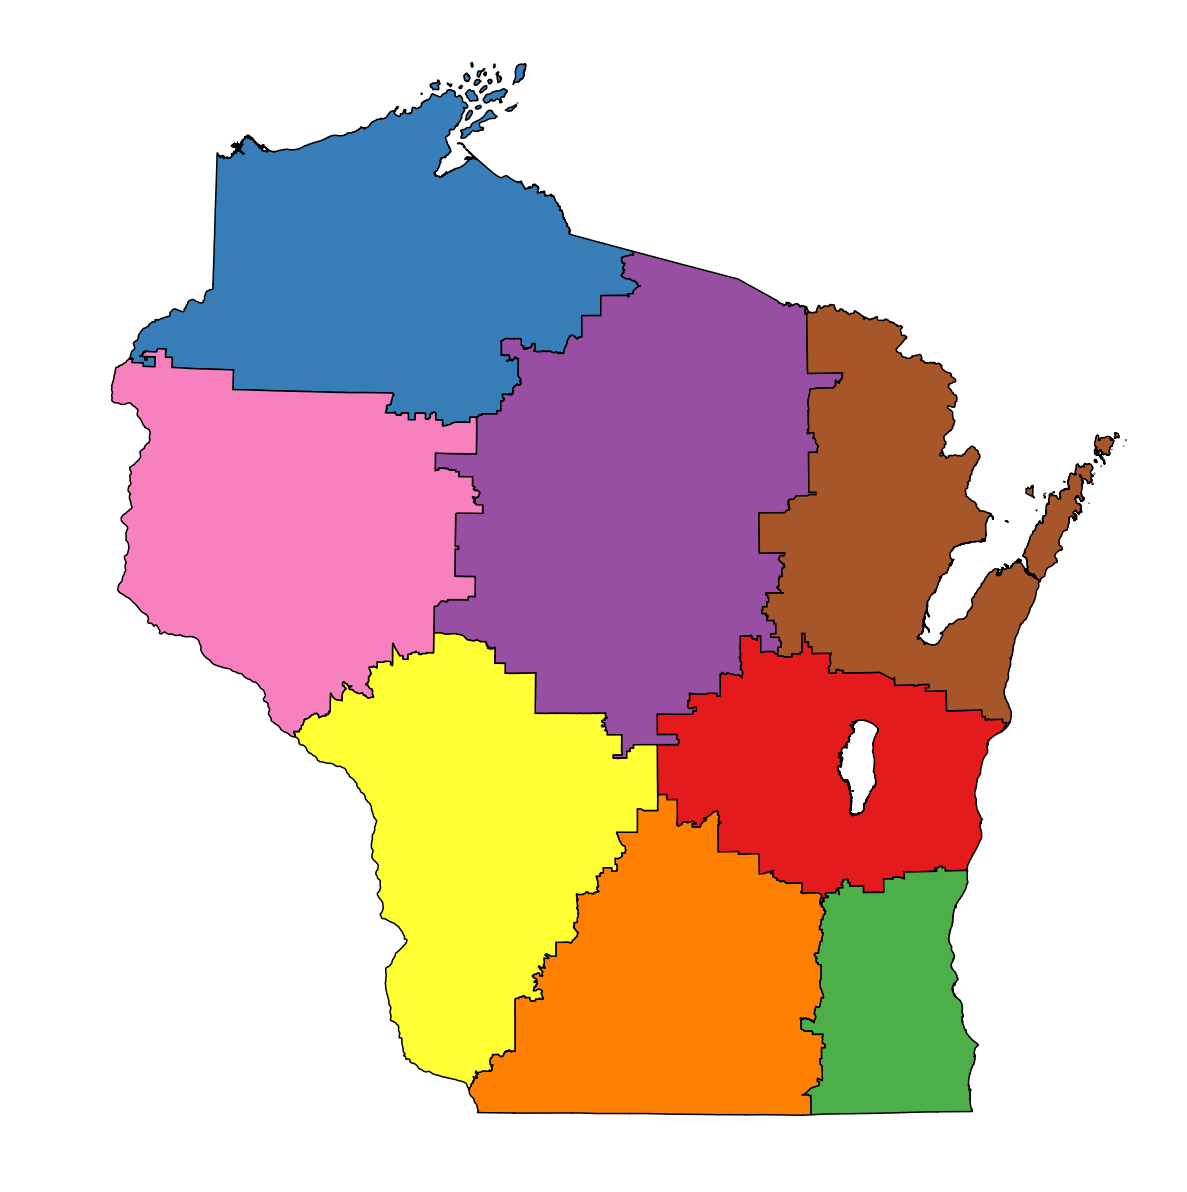

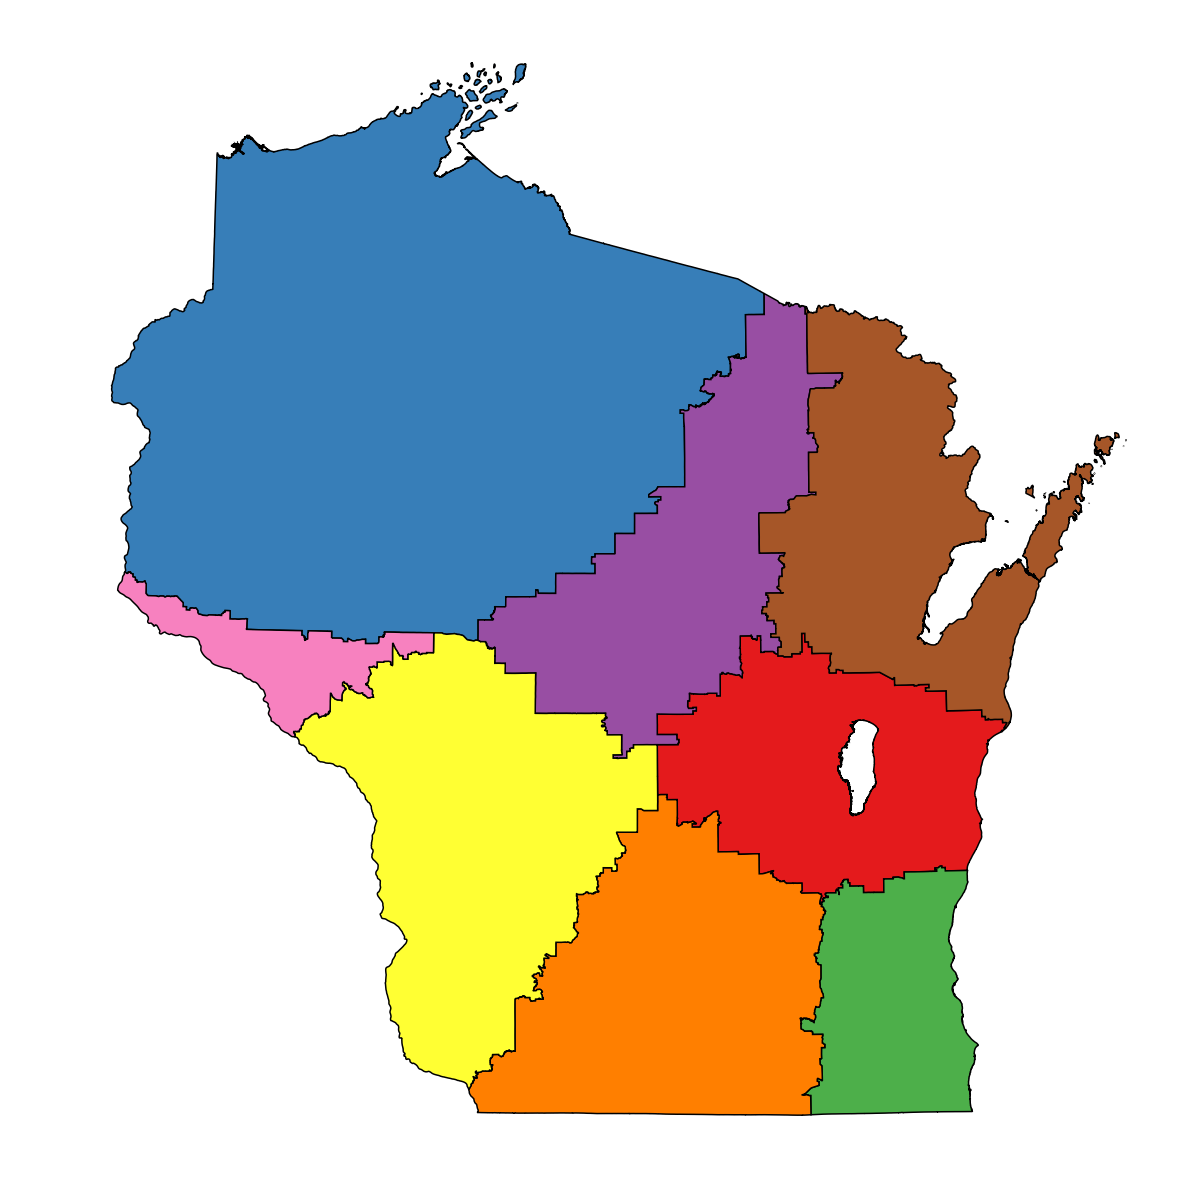

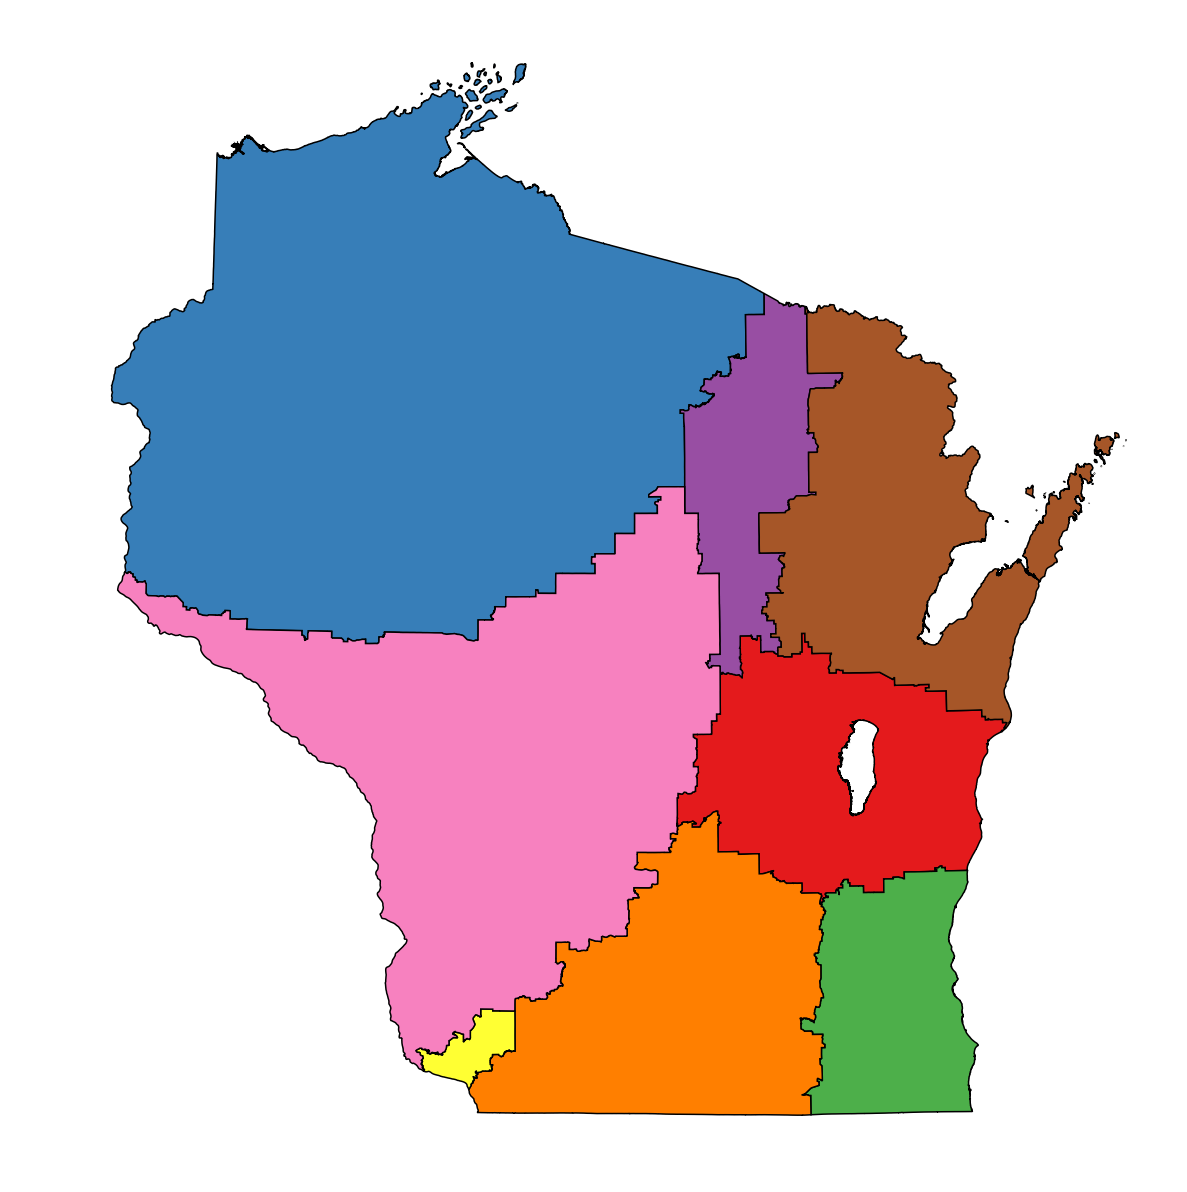

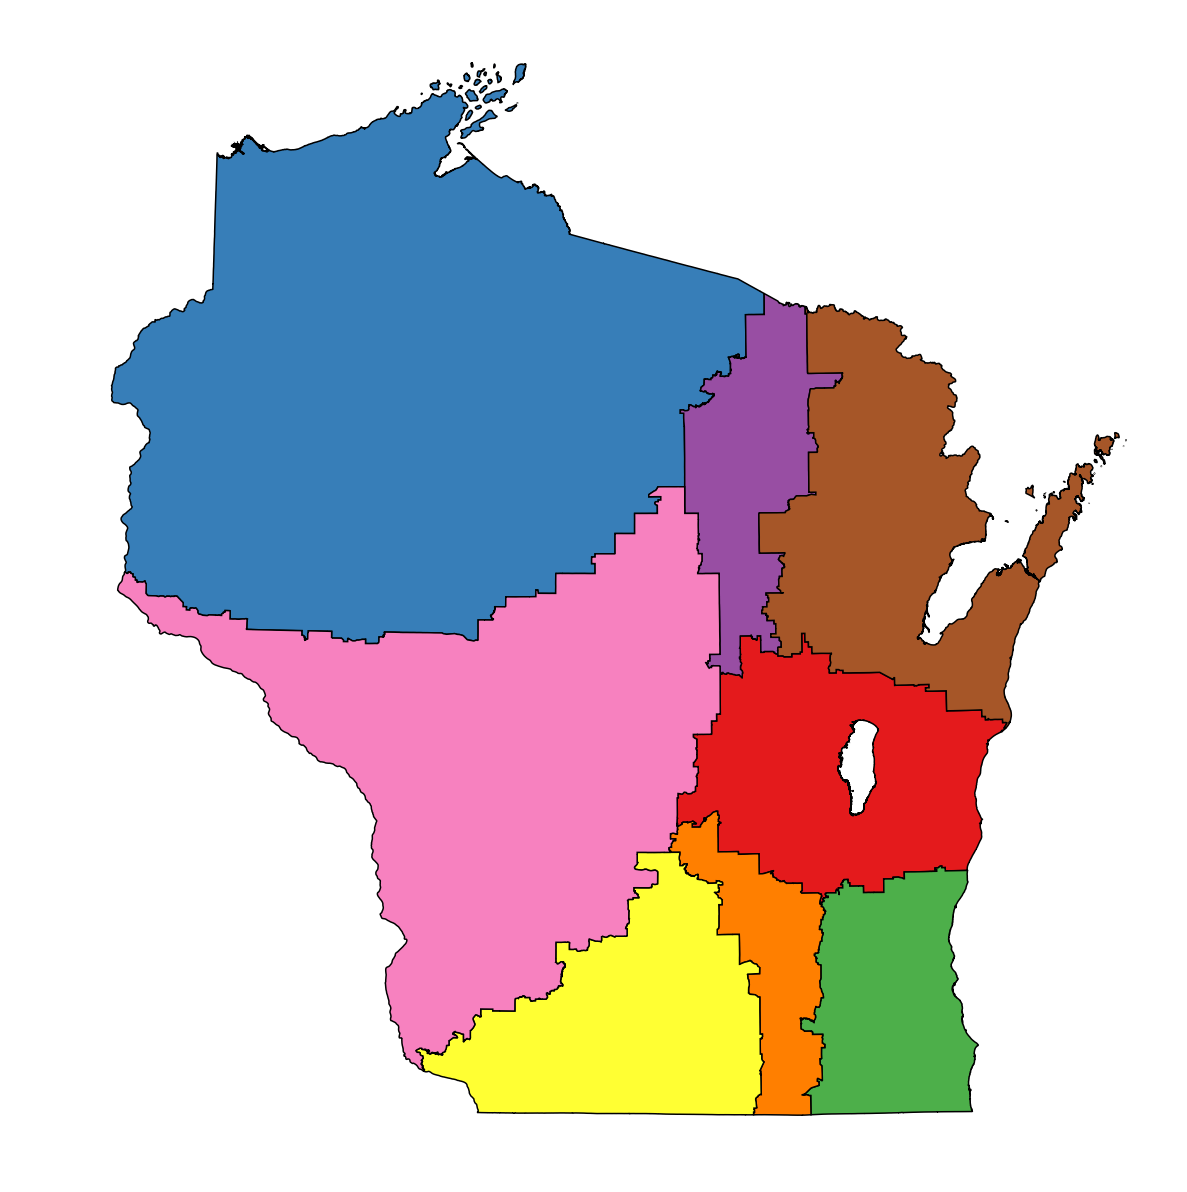

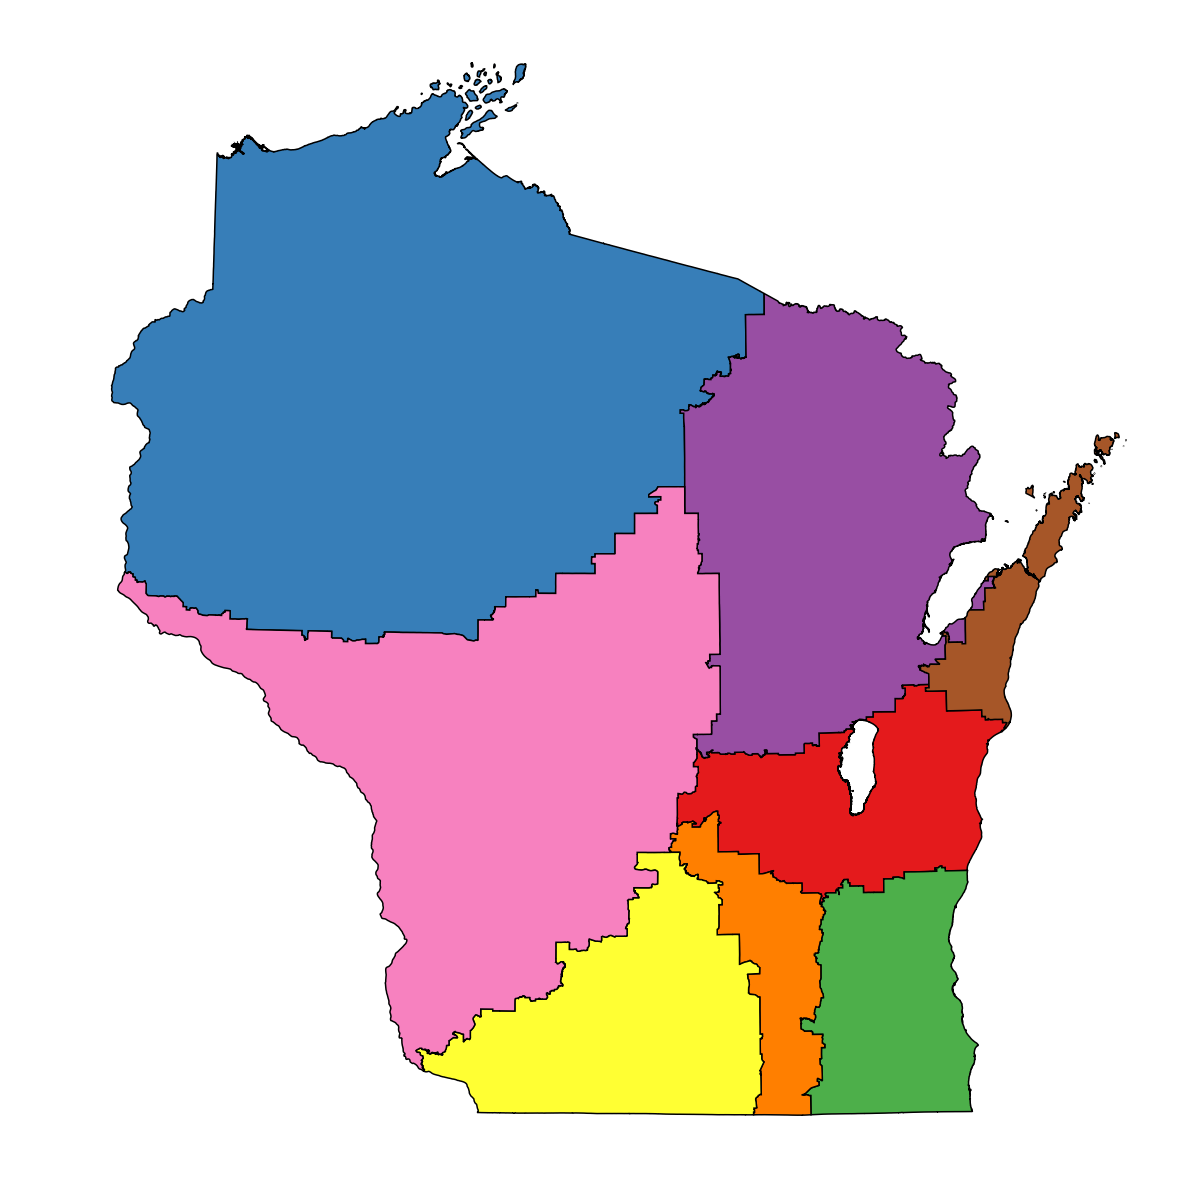

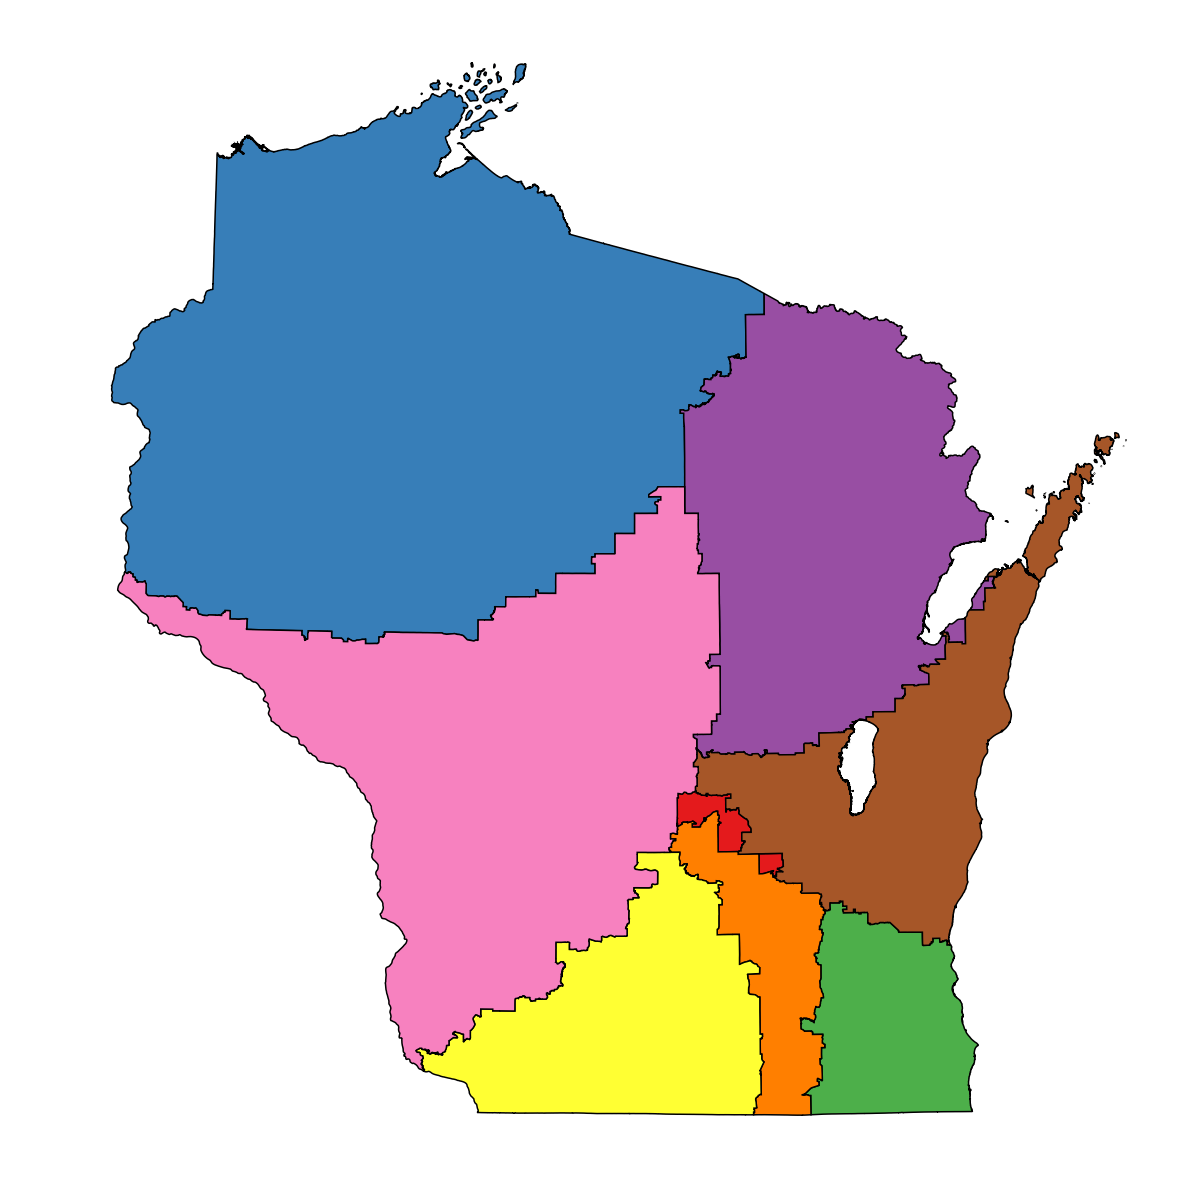

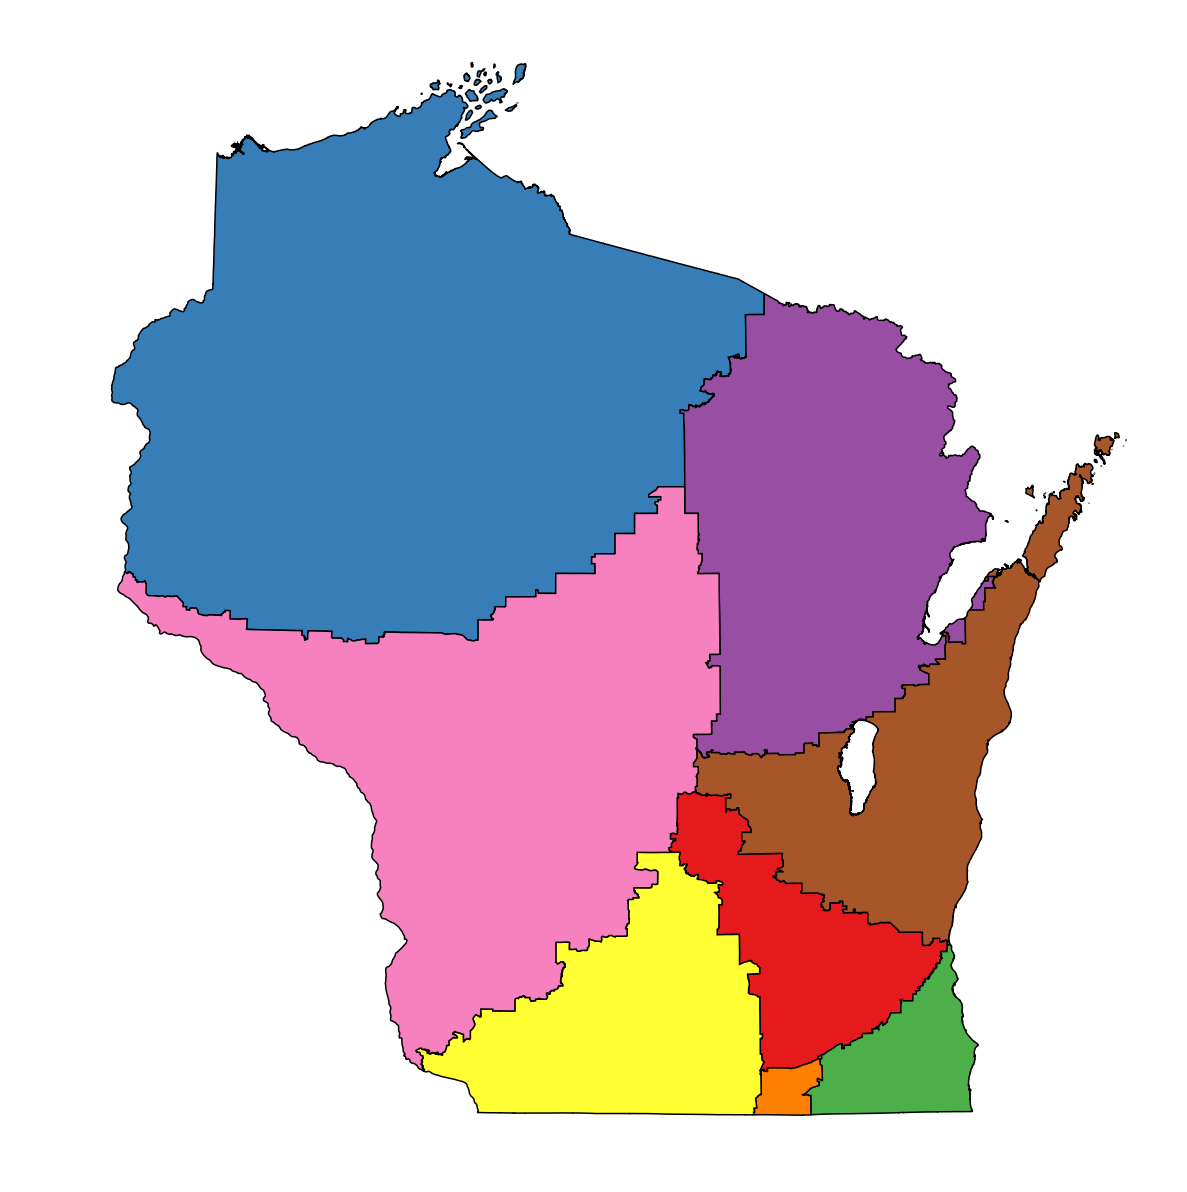

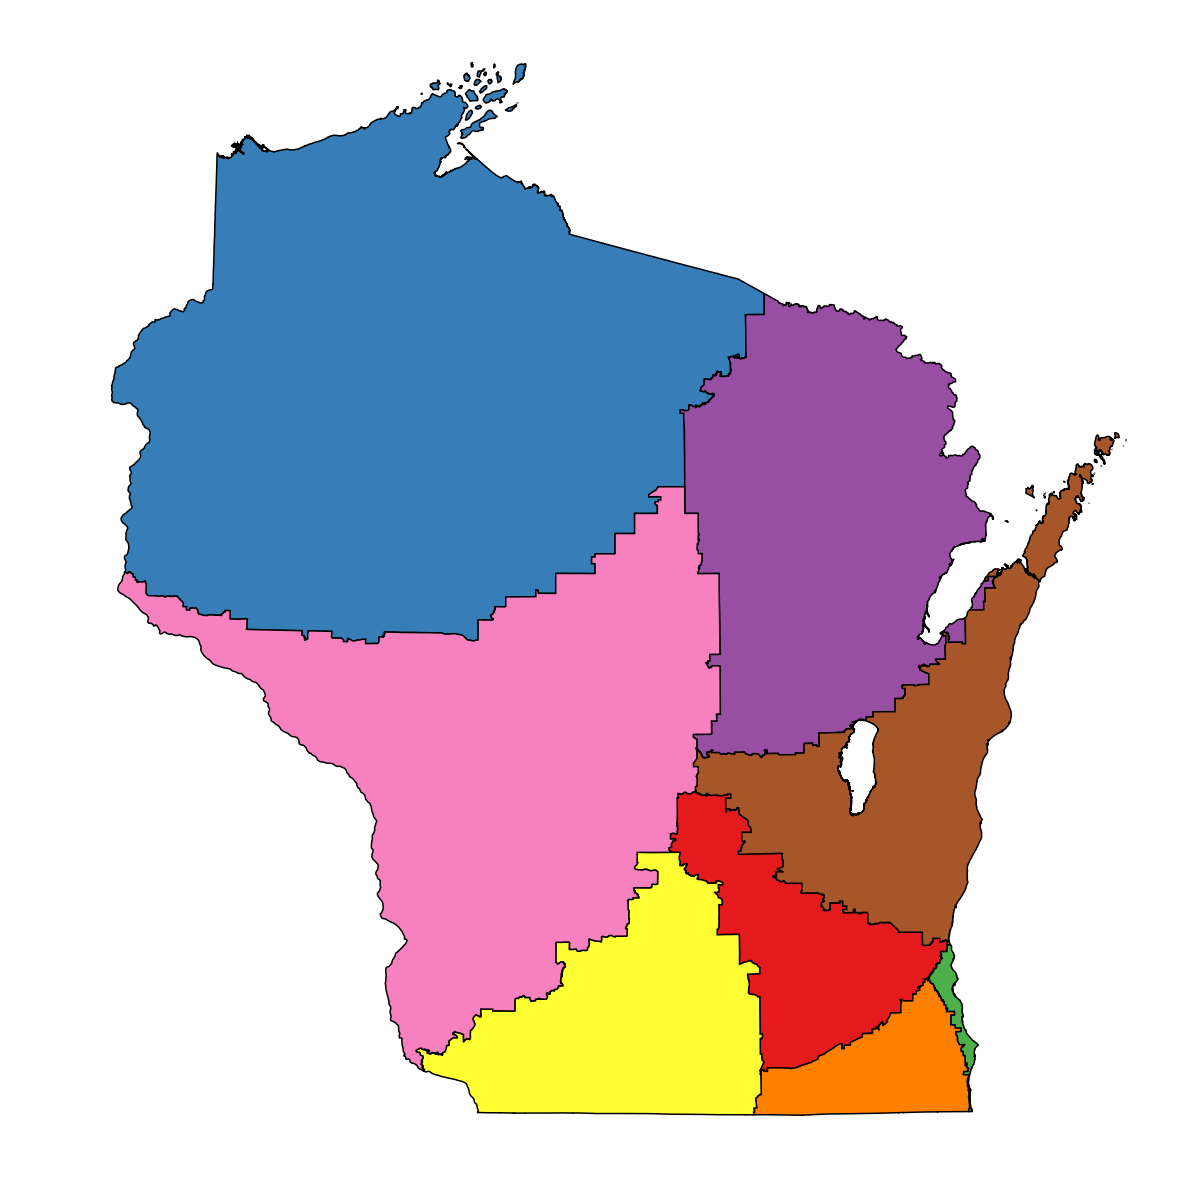

In [17]:
for step, labels in enumerate(all_labels):
    print('Starting step',step)
    
    # Assign labels to each blockgroup for current step
    for label, block in zip(labels, blocks):
        block['label'] = int(label)
        block['iscontiguous'] = False
    
    # Make blockgroups contiguous by label
    while not all([block['iscontiguous'] for block in blocks]):
        print('Making blocks contiguous')
        cleanup_blocks(blocks, labels)
        
    # Create a dictionary of districts by label, and assign
    # their (untransformed) shape to be the union of all the
    # (untransformed) shapes of the blocks with that label
    districts = [{} for label in np.unique(labels)]
    
    for label in np.unique(labels):
        districts[label]['shape'] = cascaded_union([
            block['shape']
            for block in blocks
            if block['label'] == label
        ])
        
        districts[label]['id'] = int(label) + 1
    
    # Categorical district colors
    dist_colors = [
        cm.Set1(district['id'] - 1)
        for district in districts
    ]
    
    file_location = 'images/sskmeans_s/sskmeans_step{}.png'.format(step)
    plot_shapes(
        districts, dist_colors, alpha=1,
        fig_file=file_location, cutout = wisconsin)